# Fickian Diffusion with Variable Diffusivity

In this example, we will implement a Fickian diffusion algorithm on a `Cubic` network assumming a variable diffusivity, such that diffusivity is significantly higher at high concentrations.

In [1]:
import numpy as np
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
np.random.seed(10)
ws = op.Workspace()

## Creating network 
We start by creating a 2D `Cubic` network. Note that the same procedure can be applied on extracted networks and 3D networks. Here for simplicity and visualization we chose a 2D cubic network.

In [2]:
net = op.network.Cubic([1, 15, 15], spacing=1e-5)

## Add geometry models
Next we add the `spheres_and_cylinders` collection of geometry models directly to the network obejct. This collection of geometry models assumes spherical pores and cylindrical throats. 

In [3]:
geo_models = op.models.collections.geometry.spheres_and_cylinders
net.add_model_collection(geo_models, domain='all')
net.regenerate_models() 

## Create phase
`OpenPNM` has prebuilt phase objects already available. Here we initialize a `water` phase object.

In [4]:
water = op.phase.Water(network=net)

## Adding the diffusivity model
We assume that the diffusivity of the phase water is not constant and is a function of the concentration of the species. Therefore, we define a model to calculate the `pore.diffusivity` at each concentration.

In [5]:
def variable_diffusivity(target, c_ref, pore_concentration="pore.concentration"):
    X = target[pore_concentration]
    val = 1e-9 * (1 + 5 * (X / c_ref) ** 2)
    return val

In [6]:
water.add_model(propname="pore.diffusivity", model=variable_diffusivity, c_ref=10.0,
                regen_mode="deferred")

## Add physics models
Now we add a collection of physics models to the phase object. Here we use the `basic` collection of physics models which includes the `diffusive_conductance` model. 

In [7]:
phys_models = op.models.collections.physics.basic
water.add_model_collection(phys_models, domain='all')
water.regenerate_models()

## Performing Fickian diffusion
We then add the the FickianDiffusion algorithm to our simulation and define "Dirichlet" boundary conditions assigned to the  pores that are on the top and the bottom face of the network. Note that values=10.0 for the first boundary condition means that the pore concentration of each pore (that is on the `top` boundary face) is equal to 10.0.

In [8]:
fd = op.algorithms.FickianDiffusion(network=net, phase=water)
fd.set_value_BC(pores=net.pores('top'), values=10.0)
fd.set_value_BC(pores=net.pores('bottom'), values=0.0)
fd.run()

{'pore.concentration': SteadyStateSolution([ 0.        ,  1.65972926,  3.45102646,  3.91110871,
                       4.43160003,  5.36588697,  6.46096742,  7.23130353,
                       7.78108983,  8.4091749 ,  8.8780231 ,  8.99799955,
                       9.40902575,  9.8497381 , 10.        ,  0.        ,
                       1.1648436 ,  2.85833703,  3.92491531,  4.46519584,
                       5.18491404,  6.4068187 ,  7.34164378,  7.91098266,
                       8.41091216,  8.80296126,  9.0653316 ,  9.42199572,
                       9.76566457, 10.        ,  0.        ,  1.30191627,
                       2.45059378,  3.45084066,  4.54787404,  5.46712279,
                       6.48643606,  7.23346106,  7.87536287,  8.52605712,
                       8.8097766 ,  9.02221969,  9.39670356,  9.73987593,
                      10.        ,  0.        ,  1.42660162,  2.51819884,
                       3.38104815,  4.60847886,  5.55540972,  6.49505482,
                

## Visualizing

We can visualize the average concentration distribution along the x direction (from the left boundary face towards the right boundary face)

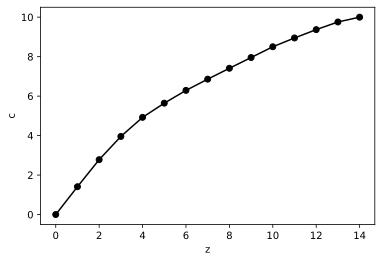

In [9]:
c=fd['pore.concentration']
fig, ax = plt.subplots()
c_xz_avg = c.reshape(op.topotools.get_shape(net)).mean(axis=(0, 1))
ax.plot(c_xz_avg, "ko-")
ax.set_xlabel(r"z")
ax.set_ylabel(r"c")
plt.show()

The concentration of species throughout the network is:

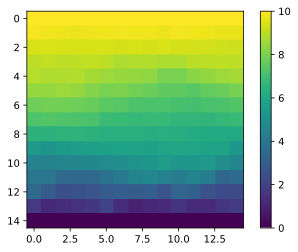

In [10]:
c2d = c.reshape(op.topotools.get_shape(net)).squeeze()
plt.imshow(np.rot90(c2d))
plt.colorbar()